# Обучение модели классификации ношения СИЗ на людях

## Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
from pprint import pformat
import typing as tp
import random

from pydantic import BaseModel, Field
import datumaro as dm
import lightning as L
from torch import optim, nn, utils, Tensor
from torchvision.models import resnet18, ResNet18_Weights
import numpy as np
from torch.utils.data import Dataset
import torch
from PIL import Image
from lightning.pytorch import LightningDataModule
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torchvision.transforms.functional as TF
from torchvision import transforms
from torchinfo import summary
from torch.functional import F

from ppe_modelling.utils import system_info_banner, current_run_tag
from ppe_modelling.logger import logger

/home/quakumei/.pyenv/versions/3.10.12/lib/python3.10/importlib/util.py:247: DeprecationWarning: The `openvino.runtime` module is deprecated and will be removed in the 2026.0 release. Please replace `openvino.runtime` with `openvino`.
  self.__spec__.loader.exec_module(self)


## System info

In [3]:
logger.info(system_info_banner())

[ppe-modelling] 17.04.2025 03:56:39 === System Information ===
System: Linux
Machine: x86_64
OS Version: #59~22.04.1-Ubuntu SMP PREEMPT_DYNAMIC Wed Mar 19 17:07:41 UTC 2
OS Name: Linux-6.8.0-57-generic-x86_64-with-glibc2.35

=== Hardware Information ===
RAM: 62.64 GB
CPU: x86_64 (20 cores)
GPU: NVIDIA GeForce RTX 3090
nvcc: nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2024 NVIDIA Corporation
Built on Thu_Mar_28_02:18:24_PDT_2024
Cuda compilation tools, release 12.4, V12.4.131
Build cuda_12.4.r12.4/compiler.34097967_0

=== Libraries Information ===
torch: 2.6; cuda: cu124
detectron2: 0.6


## Settings

In [4]:
class PPETrainSettings(BaseModel):
    datumaro_ds_dir: Path = Path('../data/ppe_classification_dataset')
    ppe_classes: list[str] = ['Safety Vest', 'Hardhat']
    output_dir: Path = Path('../logs/')
    run_tag: str = Field(default_factory=lambda x: current_run_tag()+"_ppe_classification")

settings = PPETrainSettings()

logger.info("\n" + pformat(settings.model_dump()))

[ppe-modelling] 17.04.2025 03:56:39 
{'datumaro_ds_dir': PosixPath('../data/ppe_classification_dataset'),
 'output_dir': PosixPath('../logs'),
 'ppe_classes': ['Safety Vest', 'Hardhat'],
 'run_tag': '17apr-03_56_39_ppe_classification'}


## Register Datasets

In [5]:
def read_datumaro_ds(ds_path: str, subset: str, target_attributes: list[str]) -> list[str]:
    """
        Detectron2-like 'cause it's neat
    """
    ds_dicts = []
    ds = dm.Dataset.import_from(ds_path, 'datumaro')
    for item in ds:
        if item.subset != subset:
            continue
        height,width = item.media.size #h,w
        attributes = item.annotations[0].attributes
        target = {k:v for k, v in attributes.items() if k in target_attributes}
        result_dict = {
            "file_name": item.media.path,
            "height": height,
            "width": width,
            "image_id": item.id,
            "target": target
        }
        ds_dicts.append(result_dict)
    logger.info(f"Loaded {len(ds_dicts)} samples from Datumaro '{subset}' split at {ds_path}")
    return ds_dicts

train_ds_dicts: tp.List[dict] = read_datumaro_ds(settings.datumaro_ds_dir, 'train', settings.ppe_classes)
val_ds_dicts: tp.List[dict] = read_datumaro_ds(settings.datumaro_ds_dir, 'val', settings.ppe_classes)
test_ds_dicts: tp.List[dict] = read_datumaro_ds(settings.datumaro_ds_dir, 'test', settings.ppe_classes)

[ppe-modelling] 17.04.2025 03:56:40 Loaded 3511 samples from Datumaro 'train' split at ../data/ppe_classification_dataset
[ppe-modelling] 17.04.2025 03:56:40 Loaded 104 samples from Datumaro 'val' split at ../data/ppe_classification_dataset
[ppe-modelling] 17.04.2025 03:56:40 Loaded 113 samples from Datumaro 'test' split at ../data/ppe_classification_dataset


## Define dataloaders

In [6]:
class MultiTargetClassificationDataset(Dataset):
    def __init__(
        self,
        samples: list[dict],
        target_attributes: list[str],
        image_size: tuple[int, int] = (224, 224)  # Default size
    ):
        self.samples = samples
        self.target_attributes = target_attributes
        self.label_map = {
            True: torch.tensor([1, 0], dtype=torch.float32),
            False: torch.tensor([0, 1], dtype=torch.float32),
            # None: torch.tensor([0, 0], dtype=torch.float32)
        }
        self.transform = transforms.Compose([
            transforms.Resize(224),  # Resize image
            transforms.CenterCrop(224),  # Crop image to 224x224
            transforms.ToTensor(),  # Convert image to tensor
            # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize the image
        ])

    def __len__(self) -> int:
        return len(self.samples)

    def __getitem__(self, idx: int) -> dict:
        sample = self.samples[idx]
        image = Image.open(sample["file_name"]).convert("RGB")
        image = self.transform(image)
        target = self._binary_encode_target(sample["target"])
        return {"image": image, "target": target}

    def _onehot_encode_target(self, attr_dict: dict) -> torch.Tensor:
        encoded = [self.label_map[attr_dict[attr]] for attr in self.target_attributes]
        return torch.stack(encoded)

    def _binary_encode_target(self, attr_dict: dict) -> torch.Tensor:
        helmet = attr_dict['Hardhat']
        vest = attr_dict['Safety Vest']
        return torch.tensor([int(helmet), int(vest)], dtype=torch.float32)

In [7]:
class MultiTargetDataModule(LightningDataModule):
    def __init__(
        self,
        train_data: list[dict],
        val_data: list[dict],
        test_data: list[dict],
        target_attributes: list[str],
        batch_size: int = 32,
        num_workers: int = 4
    ):
        super().__init__()
        self.train_data = train_data
        self.val_data = val_data
        self.test_data = test_data
        self.target_attributes = target_attributes
        self.batch_size = batch_size
        self.num_workers = num_workers

    def setup(self, stage: str = None):
        self.train_dataset = MultiTargetClassificationDataset(self.train_data, self.target_attributes)
        self.val_dataset = MultiTargetClassificationDataset(self.val_data, self.target_attributes)
        self.test_dataset = MultiTargetClassificationDataset(self.test_data, self.target_attributes)

    def train_dataloader(self) -> DataLoader:
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True, num_workers=self.num_workers)

    def val_dataloader(self) -> DataLoader:
        return DataLoader(self.val_dataset, batch_size=self.batch_size, shuffle=False, num_workers=self.num_workers)

    def test_dataloader(self) -> DataLoader:
        return DataLoader(self.test_dataset, batch_size=self.batch_size, shuffle=False, num_workers=self.num_workers)

data_module = MultiTargetDataModule(
    train_data=train_ds_dicts,
    val_data=val_ds_dicts,
    test_data=test_ds_dicts,
    target_attributes=settings.ppe_classes,
    batch_size=32,
    num_workers=4
)
data_module.setup()

## Visualize data

In [8]:
def visualize_samples(
    data_module: MultiTargetDataModule,
    subset: str = "train",
    num_samples: int = 4
) -> None:
    loader_map = {
        "train": data_module.train_dataloader,
        "val": data_module.val_dataloader,
        "test": data_module.test_dataloader
    }

    if subset not in loader_map:
        raise ValueError(f"Invalid subset '{subset}'. Choose from 'train', 'val', or 'test'.")

    loader = loader_map[subset]()
    batch = next(iter(loader))

    images, targets = batch["image"], batch["target"]  # targets shape: [B, N, 3]

    num_samples = min(num_samples, len(images))
    indices = random.sample(range(len(images)), num_samples)

    fig, axes = plt.subplots(num_samples, 2, figsize=(10, 4 * num_samples))

    for i, idx in enumerate(indices):
        img = images[idx].permute(1, 2, 0).numpy()
        target_tensor = targets[idx]  # shape: [num_targets, 3]

        axes[i, 0].imshow(img)
        axes[i, 0].set_title("Image")
        axes[i, 0].axis("off")

        target_text = "\n".join(
            f"{attr}: {label.tolist()}"
            for attr, label in zip(data_module.target_attributes, target_tensor)
        )
        axes[i, 1].text(0.01, 0.99, target_text, va='top', ha='left', fontsize=12)
        axes[i, 1].axis("off")
        axes[i, 1].set_title("One-hot target")

    plt.tight_layout()
    plt.show()

### Train

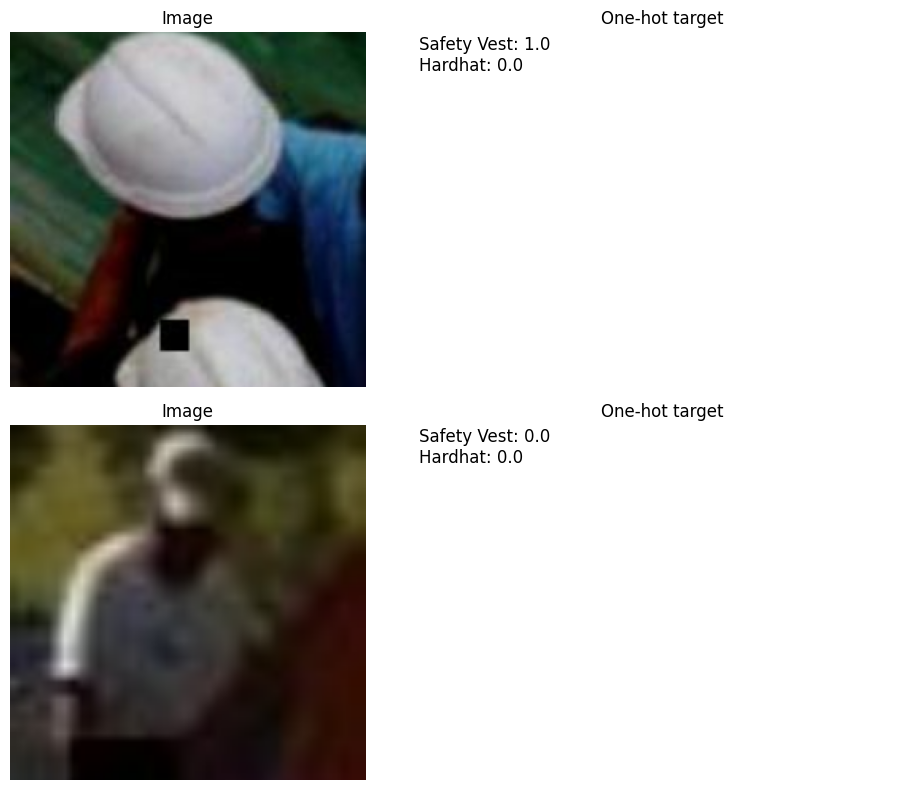

In [9]:
visualize_samples(data_module, "train", num_samples=2)

### Val

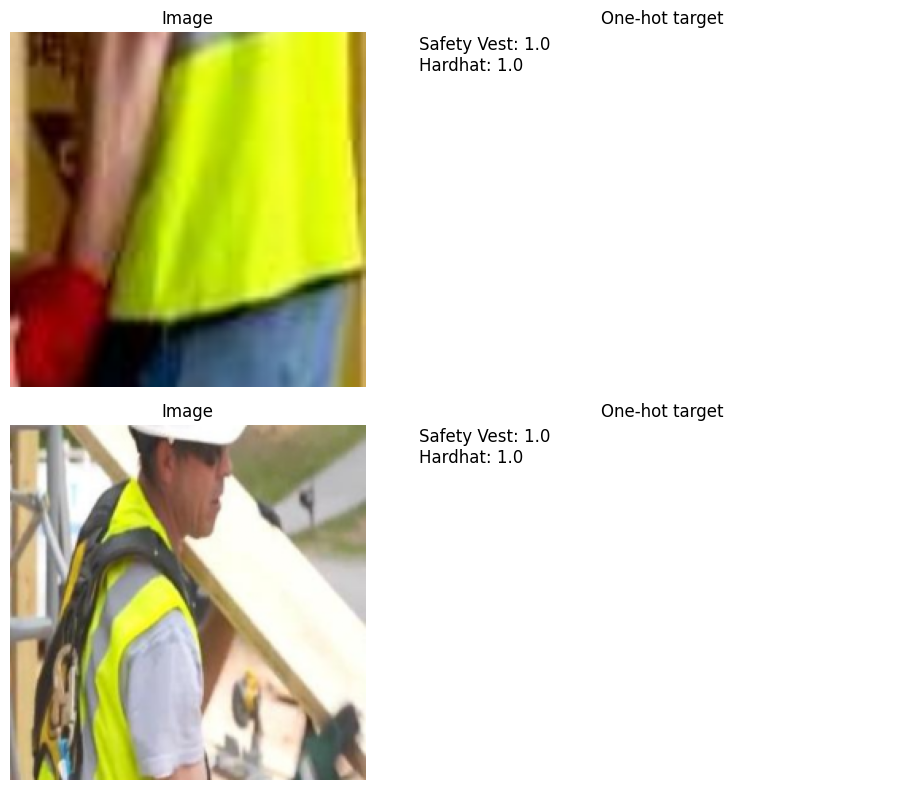

In [10]:
visualize_samples(data_module, "val", num_samples=2)

### Test

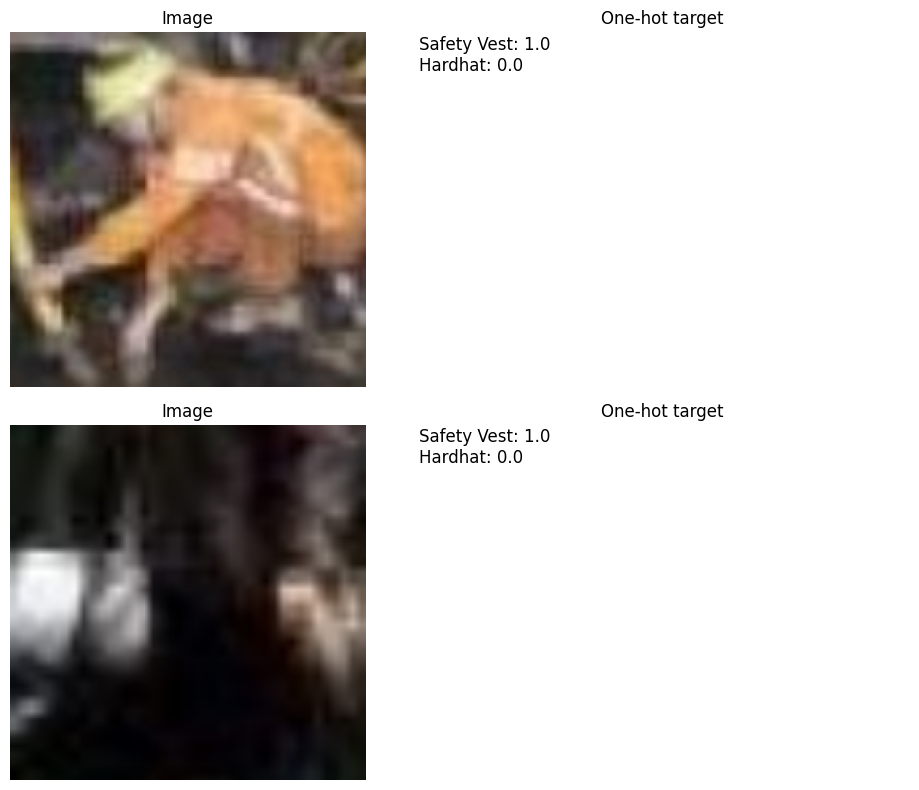

In [11]:
visualize_samples(data_module, "test", num_samples=2)

## Train

### Define configuration

In [12]:
def test_forward_pass(model: nn.Module, batch_size: int = 8, input_channels: int = 3, input_height: int = 224, input_width: int = 224):
    # Create a dummy input tensor with the shape [batch_size, input_channels, input_height, input_width]
    dummy_input = torch.randn(batch_size, input_channels, input_height, input_width)

    # Create dummy targets for the multi-target tasks, assuming each task has 2 classes
    dummy_targets = torch.randint(0, 2, (batch_size, len(model.classifiers)))  # Random targets for each task

    # Perform a forward pass
    model.eval()  # Set the model to evaluation mode to disable dropout, etc.
    with torch.no_grad():  # No need to compute gradients during the test
        outputs = model(dummy_input)

    # Ensure outputs are a list of tensors, one per target task
    assert isinstance(outputs, list), "Outputs should be a list of tensors"
    assert len(outputs) == len(model.classifiers), f"Expected {len(model.classifiers)} outputs, got {len(outputs)}"

    # Check the shape of each output
    for i, output in enumerate(outputs):
        assert output.shape == (batch_size, model.classifiers[i].out_features), \
            f"Output {i} shape mismatch: expected ({batch_size}, {model.classifiers[i].out_features}), got {output.shape}"

    print("Forward pass test passed!")

### Define trainer

In [13]:
trainer = L.Trainer(
    limit_train_batches=1.0,
    max_epochs=100,
    default_root_dir=settings.output_dir / 'ppe_classification_train_pl' / settings.run_tag,
)

You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..


### Run Train

In [ ]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchmetrics.classification import (
    MultilabelAccuracy,
    MultilabelPrecision,
    MultilabelRecall,
    MultilabelF1Score
)

class LitMultiTargetClassifier(L.LightningModule):
    def __init__(self, targets_classes_counts: tp.List[int]) -> None:
        super().__init__()
        backbone = resnet18(weights=ResNet18_Weights.DEFAULT)
        backbone.fc = nn.Identity()
        self.backbone = backbone

        self.classifiers = nn.ModuleList([
            nn.Linear(512, num_classes)
            for num_classes in targets_classes_counts
        ])
        self.loss_fn = nn.CrossEntropyLoss()

    def forward(self, x: Tensor) -> tp.List[Tensor]:
        x = self.backbone(x)
        outputs = [head(x) for head in self.classifiers]
        for output in outputs:
            assert len(output.shape) == 2
            assert output.shape[1] == 2
        return outputs

    def step(self, batch, batch_idx, loss_name):
        x = batch['image']
        targets = batch['target']
        outputs = self(x)
        loss = sum(
            self.loss_fn(output, targets[:, i])
            for i, output in enumerate(outputs)
        )
        self.log(loss_name, loss)
        return loss

    def test_step(self, batch, batch_idx):
        self.step(batch,batch_idx, "test_loss")

    def validation_step(self, batch, batch_idx):
        self.step(batch,batch_idx, "validation_loss")

    def training_step(self, batch: tp.Any, batch_idx: int) -> Tensor:
        loss = self.step(batch,batch_idx, "train_loss")
        return loss

    def configure_optimizers(self) -> optim.Optimizer:
        optimizer = optim.Adam(self.parameters(), lr=1e-4)
        scheduler = {
            'scheduler': ReduceLROnPlateau(optimizer, factor=0.1),
            'monitor': 'train_loss'
        }
        return [optimizer], [scheduler]

import timm

class LitMultiBinaryClassifier(L.LightningModule):
    def __init__(self, num_targets: int) -> None:
        super().__init__()
        backbone = resnet18(weights=ResNet18_Weights.DEFAULT)
        num_features = backbone.fc.in_features
        backbone.fc = nn.Identity()

        # model_name: str = 'mobilevitv2_100'
        # backbone = timm.create_model(model_name, pretrained=True, num_classes=0, global_pool='avg')

        self.backbone = backbone

        self.classifier = nn.Linear(num_features, num_targets)
        self.loss_fn = nn.BCEWithLogitsLoss()

        self.val_accuracy = MultilabelAccuracy(num_labels=num_targets, threshold=0.5)
        self.val_precision = MultilabelPrecision(num_labels=num_targets, threshold=0.5)
        self.val_recall = MultilabelRecall(num_labels=num_targets, threshold=0.5)
        self.val_f1 = MultilabelF1Score(num_labels=num_targets, threshold=0.5)

        self.accuracy = MultilabelAccuracy(num_labels=num_targets, threshold=0.5)
        self.precision = MultilabelPrecision(num_labels=num_targets, threshold=0.5)
        self.recall = MultilabelRecall(num_labels=num_targets, threshold=0.5)
        self.f1 = MultilabelF1Score(num_labels=num_targets, threshold=0.5)


    def forward(self, x: Tensor) -> tp.List[Tensor]:
        x = self.backbone(x)
        logits = self.classifier(x)
        return logits

    def step(self, batch, batch_idx, subset):
        x = batch['image']
        targets = batch['target']
        logits = self(x)
        loss = self.loss_fn(logits, targets)


        probs = F.sigmoid(logits) # [B, N] # mutilabel

        if subset == 'train':
            acc = self.accuracy(probs, targets.int())
            prec = self.precision(probs, targets.int())
            rec = self.recall(probs, targets.int())
            f1 = self.f1(probs, targets.int())
        elif subset == 'validation':
            acc = self.val_accuracy(probs, targets.int())
            prec = self.val_precision(probs, targets.int())
            rec = self.val_recall(probs, targets.int())
            f1 = self.val_f1(probs, targets.int())
        if subset != 'test':
            self.log(f"{subset}_loss", loss)
            self.log(f"{subset}_accuracy", acc)
            self.log(f"{subset}_precision", prec)
            self.log(f"{subset}_recall", rec)
            self.log(f"{subset}_f1", f1)
            self.log(f"{subset}_loss", loss)

        return loss

    def test_step(self, batch, batch_idx):
        self.step(batch,batch_idx, "test")

    def validation_step(self, batch, batch_idx):
        self.step(batch,batch_idx, "validation")

    def training_step(self, batch: tp.Any, batch_idx: int) -> Tensor:
        loss = self.step(batch,batch_idx, "train")
        return loss

    def configure_optimizers(self) -> optim.Optimizer:
        optimizer = optim.Adam(self.parameters(), lr=1e-3)
        scheduler = {
            'scheduler': ReduceLROnPlateau(optimizer, factor=0.1),
            'monitor': 'train_loss'
        }
        return [optimizer], [scheduler]

# model = LitMultiTargetClassifier(targets_classes_counts=[2,2])
model = LitMultiBinaryClassifier(num_targets=2)
data_module.setup()

print(summary(model))
torch.set_float32_matmul_precision('highest')
trainer.fit(
    model=model,
    datamodule=data_module,
)

You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name          | Type                | Params | Mode 
---------------------------------------------------------------
0  | backbone      | ResNet              | 11.2 M | train
1  | classifier    | Linear              | 1.0 K  | train
2  | loss_fn       | BCEWithLogitsLoss   | 0      | train
3  | val_accuracy  | MultilabelAccuracy  | 0      | train
4  | val_precision | MultilabelPrecision | 0      | train
5  | val_recall    | MultilabelRecall    | 0      | train
6  | val_f1        | MultilabelF1Score   | 0      | train
7  | accuracy      | MultilabelAccuracy  | 0      | train
8  | pr

Layer (type:depth-idx)                        Param #
LitMultiBinaryClassifier                      --
├─ResNet: 1-1                                 --
│    └─Conv2d: 2-1                            9,408
│    └─BatchNorm2d: 2-2                       128
│    └─ReLU: 2-3                              --
│    └─MaxPool2d: 2-4                         --
│    └─Sequential: 2-5                        --
│    │    └─BasicBlock: 3-1                   73,984
│    │    └─BasicBlock: 3-2                   73,984
│    └─Sequential: 2-6                        --
│    │    └─BasicBlock: 3-3                   230,144
│    │    └─BasicBlock: 3-4                   295,424
│    └─Sequential: 2-7                        --
│    │    └─BasicBlock: 3-5                   919,040
│    │    └─BasicBlock: 3-6                   1,180,672
│    └─Sequential: 2-8                        --
│    │    └─BasicBlock: 3-7                   3,673,088
│    │    └─BasicBlock: 3-8                   4,720,640
│    └─AdaptiveA

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


In [19]:
trainer.validate(model, datamodule=data_module)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
   validation_accuracy      0.8509615659713745
      validation_f1         0.7727376222610474
     validation_loss         0.882441520690918
  validation_precision      0.7917832136154175
    validation_recall       0.8102563619613647
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'validation_loss': 0.882441520690918,
  'validation_accuracy': 0.8509615659713745,
  'validation_precision': 0.7917832136154175,
  'validation_recall': 0.8102563619613647,
  'validation_f1': 0.7727376222610474}]

In [16]:
summary(model)

Layer (type:depth-idx)                        Param #
LitMultiBinaryClassifier                      --
├─ResNet: 1-1                                 --
│    └─Conv2d: 2-1                            9,408
│    └─BatchNorm2d: 2-2                       128
│    └─ReLU: 2-3                              --
│    └─MaxPool2d: 2-4                         --
│    └─Sequential: 2-5                        --
│    │    └─BasicBlock: 3-1                   73,984
│    │    └─BasicBlock: 3-2                   73,984
│    └─Sequential: 2-6                        --
│    │    └─BasicBlock: 3-3                   230,144
│    │    └─BasicBlock: 3-4                   295,424
│    └─Sequential: 2-7                        --
│    │    └─BasicBlock: 3-5                   919,040
│    │    └─BasicBlock: 3-6                   1,180,672
│    └─Sequential: 2-8                        --
│    │    └─BasicBlock: 3-7                   3,673,088
│    │    └─BasicBlock: 3-8                   4,720,640
│    └─AdaptiveA

### Metrics

## Eval model

### Infer test samples

torch.Size([32, 3, 224, 224])

In [ ]:
test_dl = data_module.test_dataloader()
sample_batch =  next(iter(test_dl))
sample_images = sample_batch['image'] # [batch-size, c, 224, 224]
sample_targets = sample_batch['target'].long().tolist()

model.eval()
with torch.inference_mode():
    res = model(sample_images)
    preds = (F.sigmoid(res) > 0.5).long().tolist()
    print(preds)

# for image in sample_images: 
# plot image write pred class write real class

[[1, 0], [1, 0], [1, 0], [1, 1], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [1, 1], [1, 1], [0, 0], [0, 0], [1, 0], [1, 0], [1, 0], [1, 1], [1, 1], [0, 0], [0, 0], [1, 0], [1, 0], [1, 0], [1, 1], [1, 0], [1, 0], [1, 0], [1, 0], [0, 0], [0, 0], [1, 1], [0, 0]]
[[1, 0], [0, 0], [0, 0], [1, 1], [1, 0], [0, 0], [0, 0], [1, 1], [1, 0], [1, 0], [1, 1], [1, 1], [0, 0], [0, 0], [1, 0], [1, 0], [1, 1], [1, 1], [0, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [0, 0], [1, 0], [0, 0], [0, 0], [1, 1], [0, 0]]


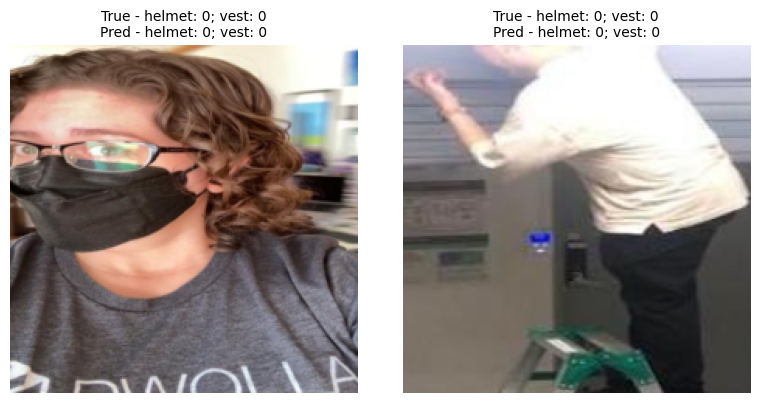

In [56]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

def plot_predictions(
    images: torch.Tensor,
    true_labels: list[list[int]],
    predicted_labels: list[list[int]],
    label_names: list[str] | None = None,
    max_items: int = 8,
) -> None:
    images = images.cpu()
    batch_size = min(len(images), max_items)
    fig, axs = plt.subplots(1, batch_size, figsize=(4 * batch_size, 4))

    if batch_size == 1:
        axs = [axs]

    for idx in range(batch_size):
        image = images[idx]
        true = true_labels[idx]
        pred = predicted_labels[idx]

        # Обработка каналов (для grayscale и RGB)
        if image.shape[0] == 1:
            image = image.squeeze(0)
        else:
            image = image.permute(1, 2, 0)

        axs[idx].imshow(image.numpy(), cmap='gray' if image.ndim == 2 else None)
        axs[idx].axis('off')

        axs[idx].set_title(f"True - helmet: {true[0]}; vest: {true[1]}\nPred - helmet: {pred[0]}; vest: {pred[1]}", fontsize=10)

    plt.tight_layout()
    plt.show()

test_dl = data_module.test_dataloader()
dl_iter = iter(test_dl)
sample_batch = next(dl_iter)
sample_batch = next(dl_iter)
# sample_batch = next(dl_iter)
# sample_batch = next(dl_iter)
sample_images = sample_batch['image']
sample_targets = sample_batch['target'].long().tolist()

model.eval()
with torch.inference_mode():
    logits = model(sample_images)
    preds = (F.sigmoid(logits) > 0.5).long().tolist()

plot_predictions(
    images=sample_images,
    true_labels=sample_targets,
    predicted_labels=preds,
    label_names=["helmet", "vest"],  # Укажи свои названия классов,
    max_items=2
)
